# **Integrating data using ingest and BBKNN**

The following tutorial describes a simple PCA-based method for integrating data we call [ingest](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.ingest.html) and compares it with [BBKNN](https://github.com/Teichlab/bbknn) [[Polanski19]](https://doi.org/10.1093/bioinformatics/btz625). BBKNN integrates well with the Scanpy workflow and is accessible through the [bbknn](https://scanpy.readthedocs.io/en/stable/external/scanpy.external.pp.bbknn.html) function.
    
The [ingest](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.ingest.html) function assumes an annotated reference dataset that captures the biological variability of interest. The rational is to fit a model on the reference data and use it to project new data. For the time being, this model is a PCA combined with a neighbor lookup search tree, for which we use UMAP's implementation [[McInnes18]](https://arxiv.org/abs/1802.03426). Similar PCA-based integrations have been used before, for instance, in [[Weinreb18]](https://doi.org/10.1101/467886).

* As [ingest](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.ingest.html) is simple and the procedure clear, the workflow is transparent and fast.
* Like BBKNN, [ingest](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.ingest.html) leaves the data matrix itself invariant.
* Unlike BBKNN, [ingest](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.ingest.html) solves the label mapping problem (like scmap) and maintains an embedding that might have desired properties like specific clusters or trajectories.

We refer to this *asymmetric* dataset integration as *ingesting* annotations from an annotated reference `adata_ref` into an `adata` that still lacks this annotation. It is different from learning a joint representation that integrates datasets in a symmetric way as [BBKNN](https://github.com/Teichlab/bbknn), Scanorma, Conos, CCA (e.g. in Seurat) or a conditional VAE (e.g. in scVI, trVAE) would do, but comparable to the initiall MNN implementation in scran. Take a look at tools in the [external API](https://scanpy.readthedocs.io/en/latest/external/#data-integration) or at the [ecoystem page](https://scanpy.readthedocs.io/en/latest/ecosystem/#data-integration) to get a start with other tools.

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import os

In [2]:
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')

-----
anndata     0.10.2
scanpy      1.9.5
-----
PIL                 10.1.0
asttokens           NA
backcall            0.2.0
cffi                1.16.0
colorama            0.4.6
comm                0.1.4
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.0
decorator           5.1.1
executing           1.2.0
h5py                3.10.0
igraph              0.11.2
ipykernel           6.23.1
ipywidgets          8.0.6
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
leidenalg           0.9.1
llvmlite            0.40.1
louvain             0.8.0
matplotlib          3.8.0
mpl_toolkits        NA
natsort             8.4.0
numba               0.57.1
numpy               1.24.3
packaging           23.2
pandas              2.1.2
parso               0.8.3
patsy               0.5.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
platformdirs        3.11.0
prompt_toolkit      3.0.39
psutil          

## **PBMCs**

We consider an annotated reference dataset `adata_ref` and a dataset for which you want to query labels and embeddings `adata`.

In [3]:
import scanpy as sc
import os

# Specify the directory containing your .h5ad files
directory = './data/merged_3_dataset/Longitudinal_profiling_of_respiratory_and_systemic_immune_responses_reveals_myeloid_cell_driven_lung_inflammation_in_severe_COVID_19/'

# List all .h5ad files in the directory and remove invisible characters
h5ad_files = [f.replace('\u200b', '') for f in os.listdir(directory) if f.endswith('.h5ad')]

# Read each .h5ad file and store the AnnData objects in a list
adata_list = [sc.read_h5ad(os.path.join(directory, file)) for file in h5ad_files]

# Concatenate all AnnData objects into a single object using anndata.concat
adata1 = sc.concat(adata_list, join='outer', label='batch')

display(adata1)


/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 55218 × 33244
    obs: 'donor_id', 'author_cell_type', 'days_post_intubation', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'batch'
    obsm: 'X_umap'

In [4]:
adata2 = sc.read_h5ad('gs://fc-656fae1b-e7e7-4ed5-af97-0df12beacd26/Analysis_Files/PS/data/Impaired_local_intrinsic_immunity_to_SARS_CoV_2_infection_in_severe_COVID_19.h5ad')
adata3 = sc.read_h5ad('./data/merged_3_dataset/Local_and_systemic_responses_to_SARS_CoV_2_infection_in_children_and_adults.h5ad')

In [5]:
# Find common genes
common_genes = (
    adata1.var_names.intersection(adata1.var_names)
    .intersection(adata2.var_names)
    .intersection(adata3.var_names)
)

# Subset data to common genes
adata1 = adata1[:, common_genes]
adata2 = adata2[:, common_genes]
adata3 = adata3[:, common_genes]


In [6]:
print(len(common_genes))

32551


In [7]:
# with open('gene_ids.txt', 'w') as f:
#     for gene_id in common_genes:
#         f.write("%s\n" % gene_id)


In [8]:
display(adata1)
display(adata2)
display(adata3)

View of AnnData object with n_obs × n_vars = 55218 × 32551
    obs: 'donor_id', 'author_cell_type', 'days_post_intubation', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'batch'
    obsm: 'X_umap'

View of AnnData object with n_obs × n_vars = 32588 × 32551
    obs: 'donor_id', 'Peak_Respiratory_Support_WHO_Score', 'Bloody_Swab', 'Percent_Mitochondrial', 'SARSCoV2_PCR_Status', 'SARSCoV2_PCR_Status_and_WHO_Score', 'Cohort_Disease_WHO_Score', 'biosample_id', 'SingleCell_SARSCoV2_RNA_Status', 'SARSCoV2_Unspliced_TRS_Total_Corrected', 'SARSCoV2_Spliced_TRS_Total_Corrected', 'SARSCoV2_NegativeStrand_Total_Corrected', 'SARSCoV2_PositiveStrand_Total_Corrected', 'SARSCoV2_Total_Corrected', 'Coarse_Cell_Annotations', 'Detailed_Cell_Annotations', 'Annotation', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'mvp.mean', 'mvp.dispersion', 'mvp.d

View of AnnData object with n_obs × n_vars = 236977 × 32551
    obs: 'sample_id', 'donor_id', 'Group', 'Ethnicity_inferred', 'Smoker', 'COVID_status', 'COVID_severity', 'First_symptoms_hospitalisation_interval', 'First_symptoms_collection_interval', 'Positive_test_collection_interval', 'Kit_version', 'dataset', 'batch', 'Cell_type_annotation_level3', 'Cell_type_annotation_level1', 'Cell_type_annotation_level2', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'n_counts_total_sarscov2', 'percent_total_sarscov2', 'n_counts_sarscov2', 'percent_sarscov2', 'scrublet_score', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'mit

### **adata1** ###

,donor_id,author_cell_type,days_post_intubation,assay_ontology_term_id,cell_type_ontology_term_id,development_stage_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,is_primary_data,organism_ontology_term_id,...,suspension_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,batch
index,,,,,,,,,,,,,,,,,,,,,
AAACGAACAGCTGTAT,COV026,epithelial,6,EFO:0009922,CL:0000066,HsapDv:0000168,MONDO:0100096,unknown,True,NCBITaxon:9606,...,cell,epithelial cell,10x 3' v3,COVID-19,Homo sapiens,female,respiratory airway,unknown,74-year-old human stage,0
AAACGCTAGTCATCGT,COV026,myeloid,6,EFO:0009922,CL:0000763,HsapDv:0000168,MONDO:0100096,unknown,True,NCBITaxon:9606,...,cell,myeloid cell,10x 3' v3,COVID-19,Homo sapiens,female,respiratory airway,unknown,74-year-old human stage,0


""
ENSG00000000003
ENSG00000000005



UMAP visualization of the data:


/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/asus/minico

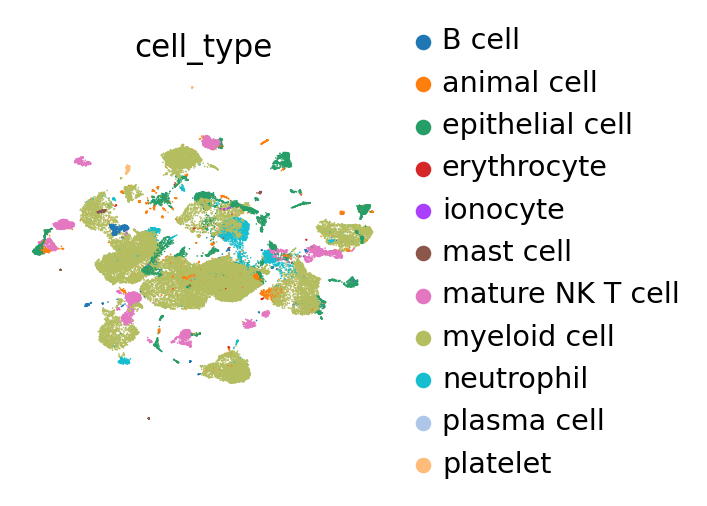

index
AAACGAACAGCTGTAT    epithelial cell
AAACGCTAGTCATCGT       myeloid cell
AAACGCTCAAACTCTG         neutrophil
AAACGCTCACTACTTT         neutrophil
AAACGCTGTCTGGTTA         neutrophil
Name: cell_type, dtype: category
Categories (11, object): ['B cell', 'animal cell', 'epithelial cell', 'erythrocyte', ..., 'myeloid cell', 'neutrophil', 'plasma cell', 'platelet']


In [9]:
display(adata1.obs.head(2))
display(adata1.var.head(2))



print("\nUMAP visualization of the data:")
sc.pl.umap(adata1, color='cell_type')



print(adata1.obs['cell_type'].head())

### **adata2** ###

,donor_id,Peak_Respiratory_Support_WHO_Score,Bloody_Swab,Percent_Mitochondrial,SARSCoV2_PCR_Status,SARSCoV2_PCR_Status_and_WHO_Score,Cohort_Disease_WHO_Score,biosample_id,SingleCell_SARSCoV2_RNA_Status,SARSCoV2_Unspliced_TRS_Total_Corrected,...,tissue_ontology_term_id,suspension_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage
GTCGGGGGGTGG_000_neg_array1,Control_Participant7,0,No,11.004785,neg,neg_0,Control_WHO_0,WHO_0_Control_Participant7,neg,0.0,...,UBERON:0001728,cell,ciliated cell,Seq-Well S3,normal,Homo sapiens,male,nasopharynx,unknown,sixth decade human stage
CAAATCAATTAT_000_neg_array1,Control_Participant7,0,No,34.210526,neg,neg_0,Control_WHO_0,WHO_0_Control_Participant7,neg,0.0,...,UBERON:0001728,cell,ciliated cell,Seq-Well S3,normal,Homo sapiens,male,nasopharynx,unknown,sixth decade human stage


,mvp.mean,mvp.dispersion,mvp.dispersion.scaled,mvp.variable,gene_symbols,feature_is_filtered,feature_name,feature_reference,feature_biotype
gene_ids,,,,,,,,,
ENSG00000000003,1.256244,2.618744,-0.357961,False,TSPAN6,False,TSPAN6,NCBITaxon:9606,gene
ENSG00000000005,0.027374,3.649929,1.086974,True,TNMD,False,TNMD,NCBITaxon:9606,gene



UMAP visualization of the data:


/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/scanpy/plottin

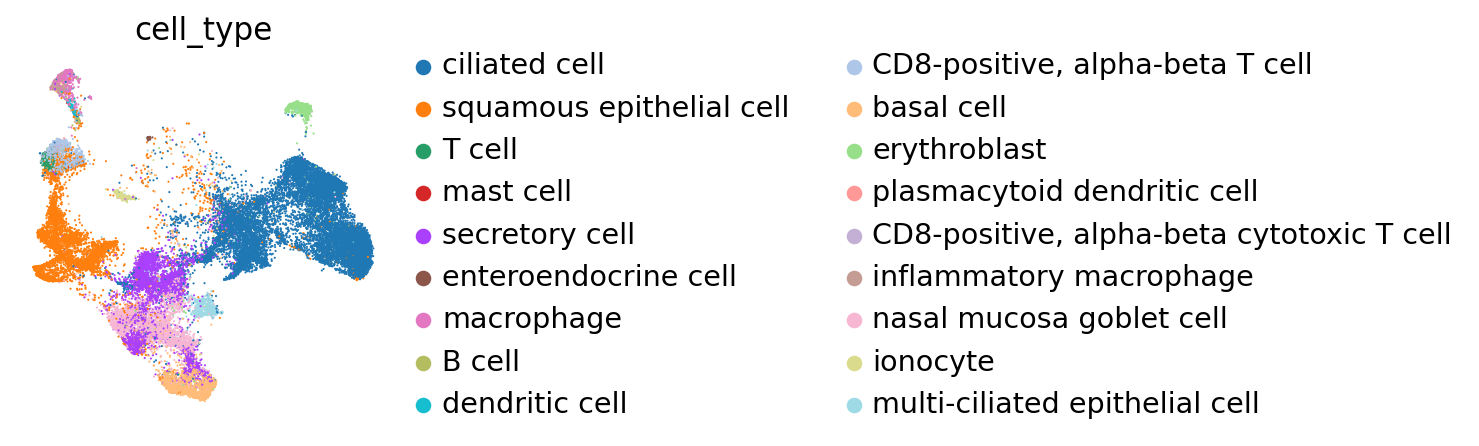

In [10]:
display(adata2.obs.head(2))
display(adata2.var.head(2))


print("\nUMAP visualization of the data:")
sc.pl.umap(adata2,color='cell_type')

### **adata3** ###

,sample_id,donor_id,Group,Ethnicity_inferred,Smoker,COVID_status,COVID_severity,First_symptoms_hospitalisation_interval,First_symptoms_collection_interval,Positive_test_collection_interval,...,tissue_ontology_term_id,suspension_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGGAGTTGC-CV001_KM8853544-ucl,NP10-NB,NP10,Ped,EUR,Non-smoker,Healthy,None,NaN,NaN,NaN,...,UBERON:0001707,cell,tracheal goblet cell,10x 5' v1,normal,Homo sapiens,male,nasal cavity,European,2-5 year-old child stage
AAACCTGAGTGGGCTA-CV001_KM8853544-ucl,NP10-NB,NP10,Ped,EUR,Non-smoker,Healthy,None,NaN,NaN,NaN,...,UBERON:0001707,cell,memory B cell,10x 5' v1,normal,Homo sapiens,male,nasal cavity,European,2-5 year-old child stage


,mito,ribo,sarscov2,gene_symbols,feature_is_filtered,feature_name,feature_reference,feature_biotype
ENSG00000000003,False,False,False,TSPAN6,False,TSPAN6,NCBITaxon:9606,gene
ENSG00000000005,False,False,False,TNMD,False,TNMD,NCBITaxon:9606,gene



UMAP visualization of the data:


/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


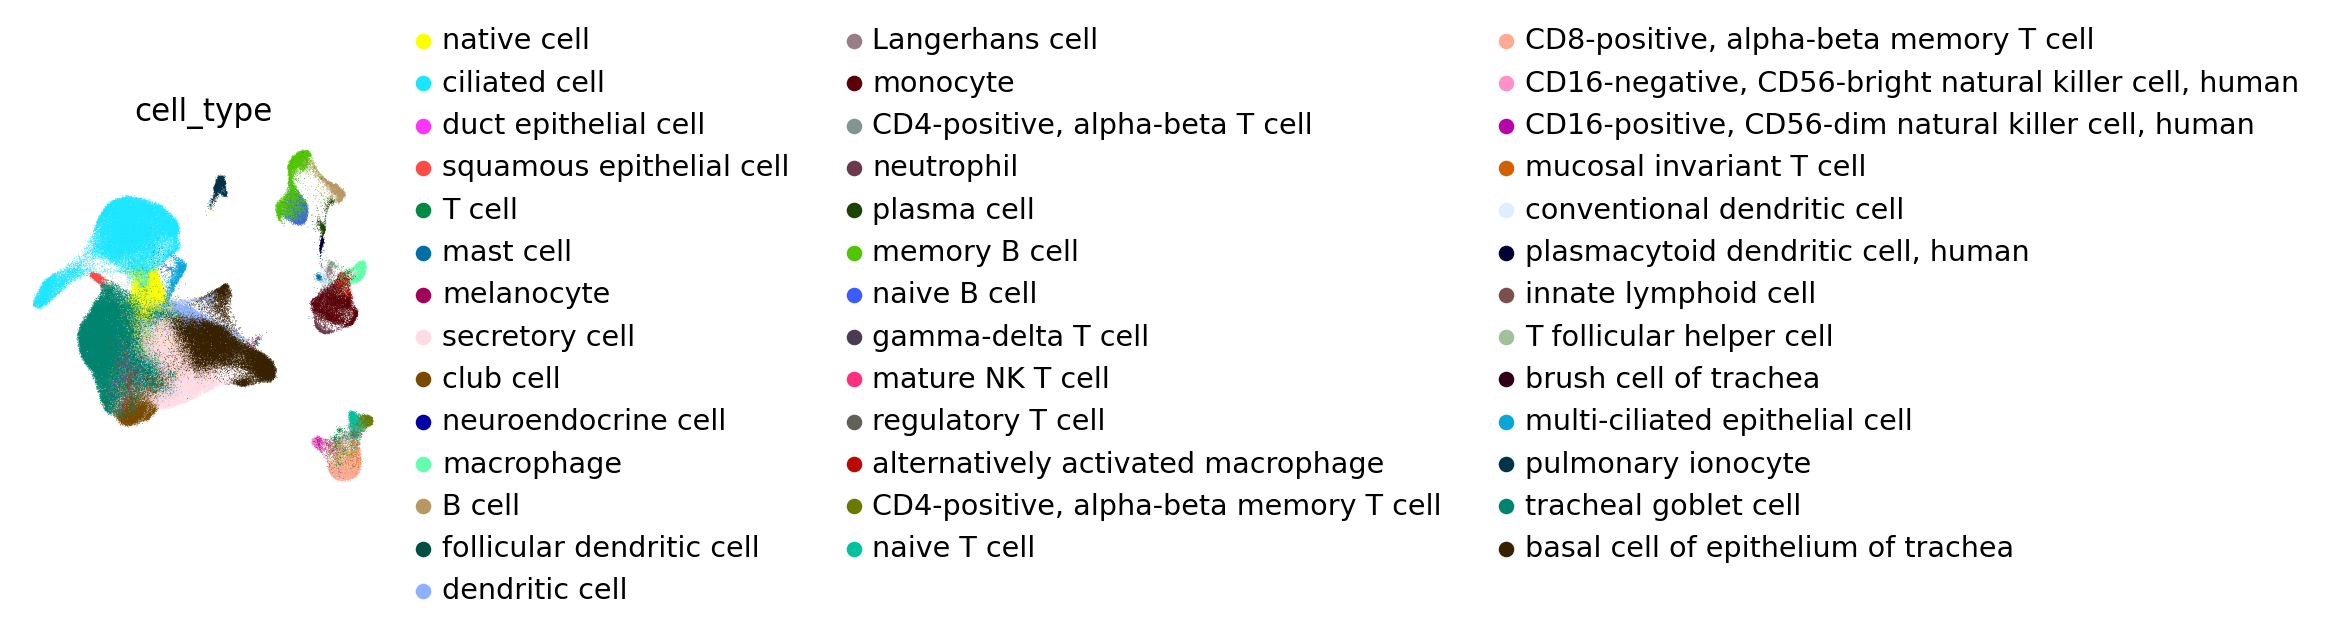

In [11]:
display(adata3.obs.head(2))
display(adata3.var.head(2))


print("\nUMAP visualization of the data:")
sc.pl.umap(adata3,color='cell_type')

### **Creating a list to store unique cell type categories for each dataset** ### 

In [12]:
# Define the dictionary with relevant keys and values
datasets = {
    'adata1': {
        'data': adata1,
        'cell_type_column': 'cell_type',
    },
    'adata2': {
        'data': adata2,
        'cell_type_column': 'cell_type',
    },
    'adata3': {
        'data': adata3,
        'cell_type_column': 'cell_type',
    }
}

# Creating a list to store unique cell type categories for each dataset
unique_cell_types = []

# Iterate through each key-value pair in the dictionary
for name, info in datasets.items():
    adata = info['data']
    cell_type_column = info['cell_type_column']
    
    # Get unique categories within the cell type column
    unique_categories = adata.obs[cell_type_column].astype('category').cat.categories
    
    # Append the unique categories to the list
    unique_cell_types.append({name: unique_categories})

# Display the list
for item in unique_cell_types:
    print(item)


{'adata1': Index(['B cell', 'animal cell', 'epithelial cell', 'erythrocyte', 'ionocyte',
       'mast cell', 'mature NK T cell', 'myeloid cell', 'neutrophil',
       'plasma cell', 'platelet'],
      dtype='object')}
{'adata2': Index(['ciliated cell', 'squamous epithelial cell', 'T cell', 'mast cell',
       'secretory cell', 'enteroendocrine cell', 'macrophage', 'B cell',
       'dendritic cell', 'CD8-positive, alpha-beta T cell', 'basal cell',
       'erythroblast', 'plasmacytoid dendritic cell',
       'CD8-positive, alpha-beta cytotoxic T cell', 'inflammatory macrophage',
       'nasal mucosa goblet cell', 'ionocyte',
       'multi-ciliated epithelial cell'],
      dtype='object')}
{'adata3': Index(['native cell', 'ciliated cell', 'duct epithelial cell',
       'squamous epithelial cell', 'T cell', 'mast cell', 'melanocyte',
       'secretory cell', 'club cell', 'neuroendocrine cell', 'macrophage',
       'B cell', 'follicular dendritic cell', 'dendritic cell',
       'Langerhans c

In [13]:
# Define a function to find and print overlapping cell types for pairs
def print_overlaps(index1, name1, index2, name2):
    set1 = set(index1)
    set2 = set(index2)
    overlap = set1.intersection(set2)
    if overlap:
        print(f"Common cell types between {name1} and {name2}:", overlap)
    else:
        print(f"No common cell types between {name1} and {name2}.")

# Extract cell types as Index objects from the unique_cell_types list
cell_types_adata1 = unique_cell_types[0]['adata1']
cell_types_adata2 = unique_cell_types[1]['adata2']
cell_types_adata3 = unique_cell_types[2]['adata3']

# Print overlaps
print_overlaps(cell_types_adata1, 'adata1', cell_types_adata2, 'adata2')
print_overlaps(cell_types_adata1, 'adata1', cell_types_adata3, 'adata3')
print_overlaps(cell_types_adata2, 'adata2', cell_types_adata3, 'adata3')


Common cell types between adata1 and adata2: {'mast cell', 'ionocyte', 'B cell'}
Common cell types between adata1 and adata3: {'mature NK T cell', 'plasma cell', 'mast cell', 'neutrophil', 'B cell'}
Common cell types between adata2 and adata3: {'ciliated cell', 'squamous epithelial cell', 'T cell', 'dendritic cell', 'macrophage', 'secretory cell', 'multi-ciliated epithelial cell', 'mast cell', 'B cell'}


### **compare or integrate datasets if they are based on different sets of genes to do at same phages** ###

#### **Create a reference dataset and find the comon genes** ####

In [ ]:
# Consider adata4 as the reference dataset
adata_ref = adata3
adata_new = [adata1, adata2]

# Ensure datasets have the same variables/features (genes)
common_genes = adata_ref.var_names
for ad in adata_new:
    common_genes = common_genes.intersection(ad.var_names)

adata_ref = adata_ref[:, common_genes]
for i in range(len(adata_new)):
    adata_new[i] = adata_new[i][:, common_genes]


/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/anndata/_core/anndata.py:1181: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df_sub[k] = df_sub[k].cat.remove_unused_categories()
/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/anndata/_core/views.py:79: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  container[idx] = value


### **Integrating Data Using ingest** ###


**The ingest method in Scanpy is an asymmetric dataset integration method, meaning that you have a well-defined reference dataset, and you are projecting other datasets onto this reference.**



In [ ]:
# Compute PCA, neighbors and UMAP on reference data
sc.pp.pca(adata_ref)



In [ ]:
sc.pp.neighbors(adata_ref)


In [ ]:
sc.tl.umap(adata_ref)


In [ ]:
sc.pl.umap(adata_ref, color='cell_type')


In [ ]:

# Ingest each adata into the reference
for ad in adata_new:
    sc.tl.ingest(ad, adata_ref, obs='cell_type')
    sc.pl.umap(ad, color='cell_type')

## **Integrating Data Using BBKNN** ##
**For BBKNN, you concatenate datasets and perform the integration:**

In [ ]:
# Concatenate all datasets
adata_concat = adata_ref.concatenate(adata_new, batch_key='dataset')

# PCA on the concatenated data
sc.tl.pca(adata_concat)

# Integrate using BBKNN
sc.external.pp.bbknn(adata_concat, batch_key='dataset')
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=['dataset', 'cell_type'])


In [ ]:
# Intersect genes between the two datasets
common_genes = adata_ref.var.index.intersection(adata.var.index)

# Subset datasets to only include common genes
adata_ref = adata_ref[:, common_genes]
adata = adata[:, common_genes]

# Convert to dataframes
df_ref = pd.DataFrame(adata_ref.X.todense(), index=adata_ref.obs.index, columns=common_genes)
df = pd.DataFrame(adata.X.todense(), index=adata.obs.index, columns=common_genes)

# Display the first few rows of each dataframe
print(df_ref.head())
print(df.head())


To use `sc.tl.ingest`, the datasets need to be defined on the same variables.

In [ ]:
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]

The model and graph (here PCA, neighbors, UMAP) trained on the reference data will explain the biological variation observed within it.

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='umap')


In [ ]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

The manifold still looks essentially the same as in the [clustering tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

In [ ]:
sc.tl.louvain(adata_ref)


In [ ]:
sc.pl.umap(adata_ref, color='louvain')


### **Mapping PBMCs using ingest**

Let's map labels and embeddings from `adata_ref` to `adata` based on a chosen representation. Here, we use `adata_ref.obsm['X_pca']` to map cluster labels and the UMAP coordinates.

In [ ]:
sc.tl.ingest(adata, adata_ref, obs='louvain')

adata.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix colors

print(adata.obs.columns)

# Check if 'bulk_labels' exists in adata_ref.obs
if 'bulk_labels' in adata_ref.obs.columns:
    # Ingest the data from adata_ref to adata
    sc.tl.ingest(adata, adata_ref, obs='louvain')

    # Update the color schemes for the louvain clusters
    adata.uns['louvain_colors'] = adata_ref.uns['louvain_colors']

    # Visualize using UMAP
    sc.pl.umap(adata, color=['louvain', 'bulk_labels'], wspace=0.5)
else:
    print("'bulk_labels' not found in adata_ref. Visualizing only with 'louvain' clusters.")
    sc.pl.umap(adata, color='louvain')


By comparing the 'bulk_labels' annotation with 'louvain', we see that the data has been reasonably mapped, only the annotation of dendritic cells seems ambiguous and might have been ambiiguous in `adata` already.

In [ ]:
adata_concat = adata_ref.concatenate(adata, batch_categories=['ref', 'new'])

In [ ]:
adata_concat.obs.louvain = adata_concat.obs.louvain.astype('category')
adata_concat.obs.louvain = adata_concat.obs.louvain.cat.reorder_categories(adata_ref.obs.louvain.cat.categories)  # fix category ordering
adata_concat.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix category colors


In [ ]:
sc.pl.umap(adata_concat, color=['batch', 'louvain'])

While there seems to be some batch-effect in the monocytes and dendritic cell clusters, the new data is otherwise mapped relatively homogeneously.

The megakaryoctes are only present in `adata_ref` and no cells from `adata` map onto them. If interchanging reference data and query data, Megakaryocytes do not appear as a separate cluster anymore. This is an extreme case as the reference data is very small; but one should always question if the reference data contain enough biological variation to meaningfully accomodate query data.

### **Using BBKNN**

In [ ]:
sc.tl.pca(adata_concat)

In [ ]:
%%time
sc.external.pp.bbknn(adata_concat, batch_key='batch')  # running bbknn 1.3.6

In [ ]:
sc.tl.umap(adata_concat)

In [ ]:
sc.pl.umap(adata_concat, color=['batch', 'louvain'])

Also BBKNN doesn't maintain the Megakaryocytes cluster. However, it seems to mix cells more homogeneously.

## **Pancreas**

The following data has been used in the scGen paper [[Lotfollahi19]](https://doi.org/10.1038/s41592-019-0494-8), has been used [here](https://nbviewer.jupyter.org/github/M0hammadL/scGen_notebooks/blob/master/notebooks/scgen_batch_removal.ipynb), was curated [here](https://nbviewer.jupyter.org/github/Teichlab/bbknn/blob/master/examples/pancreas.ipynb) and can be downloaded from [here (the BBKNN paper)](ftp://ngs.sanger.ac.uk/production/teichmann/BBKNN/objects-pancreas.zip).

It contains data for human pancreas from 4 different studies (Segerstolpe16, Baron16, Wang16, Muraro16), which have been used in the seminal papers on single-cell dataset integration (Butler18, Haghverdi18) and many times ever since.

In [ ]:
# note that this collection of batches is already intersected on the genes
# adata_all = sc.read('data/pancreas.h5ad', backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')

In [ ]:
adata_all  = sc.read_h5ad('./data/merged_3_dataset/Impaired_local_intrinsic_immunity_to_SARS_CoV_2_infection_in_severe_COVID_19.h5ad')

In [ ]:
adata_all.shape

Inspect the cell types observed in these studies.

In [ ]:
counts = adata_all.obs.Coarse_Cell_Annotations.value_counts()
print(counts)



To simplify visualization, let's remove the 5 minority classes.

In [ ]:
minority_classes = counts.index[-5:].tolist()  # get the minority classes
adata_all = adata_all[~adata_all.obs.Coarse_Cell_Annotations.isin(minority_classes)]  # subset data

# reorder categories and assign back to the dataframe
adata_all.obs.Coarse_Cell_Annotations = adata_all.obs.Coarse_Cell_Annotations.cat.reorder_categories(counts.index[:-5].tolist())


### **Seeing the batch effect**

In [ ]:
sc.pp.pca(adata_all)
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)

We observe a batch effect.

In [ ]:
for col in adata_all.obs.columns:
    print(f"{col}: {adata_all.obs[col].unique()}")


### **BBKNN**

It can be well-resolved using [BBKNN](https://github.com/Teichlab/bbknn) [[Polanski19]](https://doi.org/10.1093/bioinformatics/btz625).

In [ ]:
%%time
sc.external.pp.bbknn(adata_all, batch_key='batch')

In [ ]:
sc.tl.umap(adata_all)

In [ ]:
sc.pl.umap(adata_all, color=['batch', 'celltype'])

If one prefers to work more iteratively starting from one reference dataset, one can use ingest.

### **Mapping onto a reference batch using ingest**

Choose one reference batch for training the model and setting up the neighborhood graph (here, a PCA) and separate out all other batches.

As before, the model trained on the reference batch will explain the biological variation observed within it.

In [ ]:
adata_ref = adata_all[adata_all.obs.batch == '0']

Compute the PCA, neighbors and UMAP on the reference data.

In [ ]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

The reference batch contains 12 of the 19 cell types across all batches.

In [ ]:
sc.pl.umap(adata_ref, color='celltype')

Iteratively map labels (such as 'celltype') and embeddings (such as 'X_pca' and 'X_umap') from the reference data onto the query batches.

In [ ]:
adatas = [adata_all[adata_all.obs.batch == i].copy() for i in ['1', '2', '3']]

In [ ]:
sc.settings.verbosity = 2  # a bit more logging
for iadata, adata in enumerate(adatas):
    print(f'... integrating batch {iadata+1}')
    adata.obs['celltype_orig'] = adata.obs.celltype  # save the original cell type
    sc.tl.ingest(adata, adata_ref, obs='celltype')

Each of the query batches now carries annotation that has been contextualized with `adata_ref`. By concatenating, we can view it together.

In [ ]:
adata_concat = adata_ref.concatenate(adatas)

In [ ]:
adata_concat.obs.celltype = adata_concat.obs.celltype.astype('category')
adata_concat.obs.celltype = adata_concat.obs.celltype.cat.reorder_categories(adata_ref.obs.celltype.cat.categories)  # fix category ordering
adata_concat.uns['celltype_colors'] = adata_ref.uns['celltype_colors']  # fix category coloring

In [ ]:
sc.pl.umap(adata_concat, color=['batch', 'celltype'])

Compared to the BBKNN result, this is maintained clusters in a much more pronounced fashion. If one already observed a desired continuous structure (as in the hematopoietic datasets, for instance), `ingest` allows to easily maintain this structure.

### **Evaluating consistency**

Let us subset the data to the query batches.

In [ ]:
adata_query = adata_concat[adata_concat.obs.batch.isin(['1', '2', '3'])]

The following plot is a bit hard to read, hence, move on to confusion matrices below.

In [ ]:
sc.pl.umap(
    adata_query, color=['batch', 'celltype', 'celltype_orig'], wspace=0.4)

#### **Cell types conserved across batches**

Let us first focus on cell types that are conserved with the reference, to simplify reading of the confusion matrix.

In [ ]:
obs_query = adata_query.obs
conserved_categories = obs_query.celltype.cat.categories.intersection(obs_query.celltype_orig.cat.categories)  # intersected categories
obs_query_conserved = obs_query.loc[obs_query.celltype.isin(conserved_categories) & obs_query.celltype_orig.isin(conserved_categories)]  # intersect categories

obs_query_conserved['celltype'] = obs_query_conserved.celltype.cat.remove_unused_categories()  # remove unused categories
obs_query_conserved['celltype_orig'] = obs_query_conserved.celltype_orig.cat.remove_unused_categories()  # remove unused categories

# For the reorder_categories method:
obs_query_conserved['celltype_orig'] = obs_query_conserved.celltype_orig.cat.reorder_categories(obs_query_conserved.celltype.cat.categories)  # fix category ordering


In [ ]:
pd.crosstab(obs_query_conserved.celltype, obs_query_conserved.celltype_orig)

Overall, the conserved cell types are also mapped as expected. The main exception are some acinar cells in the original annotation that appear as acinar cells. However, already the reference data is observed to feature a cluster of both acinar and ductal cells, which explains the discrepancy, and indicates a potential inconsistency in the initial annotation.

#### **All cell types**

Let us now move on to look at all cell types.

In [ ]:
pd.crosstab(adata_query.obs.celltype, adata_query.obs.celltype_orig)

We observe that PSC ([pancreatic stellate cells](https://en.wikipedia.org/wiki/Pancreatic_stellate_cell)) cells are in fact just inconsistently annotated and correctly mapped on 'activated_stellate' cells.

Also, it's nice to see that 'mesenchyme' and 'mesenchymal' cells both map onto the same category. However, that category is again 'activated_stellate' and likely incorrect.

### **Visualizing distributions across batches**

Often, batches correspond to experiments that one wants to compare. Scanpy offers to convenient visualization possibilities for this.

1. a density plot
2. a partial visualization of a subset of categories/groups in an emnbedding

#### **Density plot**

In [ ]:
sc.tl.embedding_density(adata_concat, groupby='batch')

In [ ]:
sc.pl.embedding_density(adata_concat, groupby='batch')

#### **Partial visualizaton of a subset of groups in embedding**

In [ ]:
for batch in ['1', '2', '3']:
    sc.pl.umap(adata_concat, color='batch', groups=[batch])